In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import seaborn as sns

In [16]:
import lightgbm as lgb
from explainerdashboard import ExplainerDashboard, ClassifierExplainer

In [2]:
df = pd.read_csv('cs-training.csv', index_col=0)
df.head(2)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0


### Analysis

In [3]:
df.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [4]:
df.isnull().mean()

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.198207
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.026160
dtype: float64

### Preparation

Implement for Gradient Boosting Algorithm

- CatBoost: Yadex, No tuning
- XGboost: Washington University
- LightGBM: Microsoft --> data > 10,000

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='SeriousDlqin2yrs'), df.SeriousDlqin2yrs, test_size=0.15,
                                                   shuffle=True, stratify=df.SeriousDlqin2yrs, random_state=9)

valid_size = y_test.shape[0] / y_train.shape[0]

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_size,
                                                   shuffle=True, stratify=y_train, random_state=9)

In [10]:
X_train.shape, X_test.shape, X_valid.shape

((105000, 10), (22500, 10), (22500, 10))

In [15]:
df.SeriousDlqin2yrs.value_counts(normalize=True) * 100

0    93.316
1     6.684
Name: SeriousDlqin2yrs, dtype: float64

In [12]:
y_train.value_counts(normalize=True) * 100

0    93.31619
1     6.68381
Name: SeriousDlqin2yrs, dtype: float64

In [13]:
y_test.value_counts(normalize=True) * 100

0    93.315556
1     6.684444
Name: SeriousDlqin2yrs, dtype: float64

In [14]:
y_valid.value_counts(normalize=True) * 100

0    93.315556
1     6.684444
Name: SeriousDlqin2yrs, dtype: float64

In [19]:
X_train.shape

(120000, 10)

### Modeling

In [17]:
train_set = lgb.Dataset(X_train, y_train)
valid_set = lgb.Dataset(X_valid, y_valid)
test_set = lgb.Dataset(X_test, y_test)

In [33]:
params = {
    'objective': 'binary',
    'boosting': 'gbdt',
    'metric': ['binary_logloss', 'auc'],
    'learning_rate': 0.001,
    'max_depth': 5,
    'num_leaves': 10,
    'min_data_in_leaf': 1000,
    'bagging_fraction': 1,
    'feature_fraction': 1,
    'n_jobs': 8
}

eval_result = {}
model = lgb.train(params, train_set, num_boost_round=2000, valid_sets=[train_set, valid_set], evals_result=eval_result, verbose_eval=0)

[LightGBM] [Info] Number of positive: 7018, number of negative: 97982
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 973
[LightGBM] [Info] Number of data points in the train set: 105000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066838 -> initscore=-2.636306
[LightGBM] [Info] Start training from score -2.636306


### Evaluation

In [34]:
eval_result.get('training').keys()

odict_keys(['binary_logloss', 'auc'])

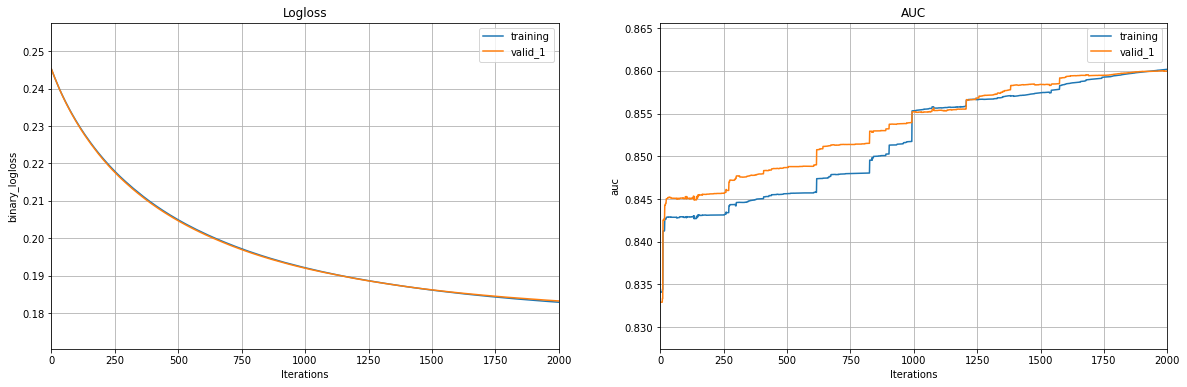

In [35]:
_, ax = plt.subplots(1, 2, figsize=(20, 6))
lgb.plot_metric(eval_result, metric='binary_logloss', title='Logloss', ax=ax[0])
lgb.plot_metric(eval_result, metric='auc', title='AUC', ax=ax[1]);

In [38]:
y_pred = model.predict(X_test)

In [39]:
y_pred

array([0.01948672, 0.01838379, 0.03634457, ..., 0.18378945, 0.05702642,
       0.19943256])

In [42]:
roc_auc_score(y_test, y_pred)

0.8611710772923313

### SKLEARN API

In [46]:
params = {
    'objective': 'binary',
    'boosting': 'gbdt',
    'metric': ['binary_logloss', 'auc'],
    'learning_rate': 0.001,
    'max_depth': 5,
    'num_leaves': 10,
    'min_data_in_leaf': 1000,
    'bagging_fraction': 1,
    'feature_fraction': 1,
    'n_jobs': 8,
    'n_estimators': 2000,
}

model = lgb.LGBMClassifier(**params)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=0)

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


LGBMClassifier(bagging_fraction=1, boosting='gbdt', feature_fraction=1,
               learning_rate=0.001, max_depth=5,
               metric=['binary_logloss', 'auc'], min_data_in_leaf=1000,
               n_estimators=2000, n_jobs=8, num_leaves=10, objective='binary')

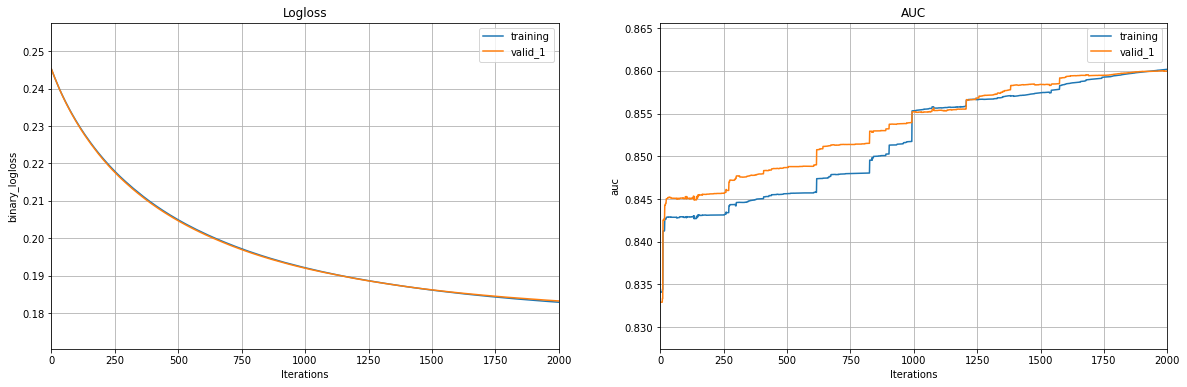

In [49]:
_, ax = plt.subplots(1, 2, figsize=(20, 6))
lgb.plot_metric(model.evals_result_, metric='binary_logloss', title='Logloss', ax=ax[0])
lgb.plot_metric(model.evals_result_, metric='auc', title='AUC', ax=ax[1]);

In [52]:
y_pred = model.predict_proba(X_test)[:, 1]

In [53]:
roc_auc_score(y_test, y_pred)

0.8611710772923313

### Calibration

In [55]:
prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10, normalize=True)

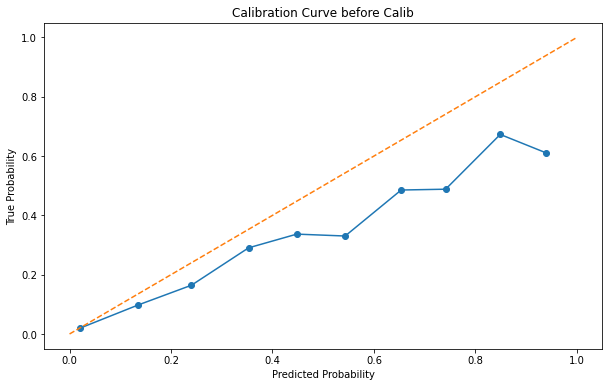

In [57]:
plt.figure(figsize=(10, 6))
plt.scatter(prob_pred, prob_true)
plt.plot(prob_pred, prob_true)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve before Calib')
plt.show()

In [76]:
calib_model = CalibratedClassifierCV(model, cv='prefit', n_jobs=8, method='isotonic')
calib_model.fit(X_valid, y_valid)

CalibratedClassifierCV(base_estimator=LGBMClassifier(bagging_fraction=1,
                                                     boosting='gbdt',
                                                     feature_fraction=1,
                                                     learning_rate=0.001,
                                                     max_depth=5,
                                                     metric=['binary_logloss',
                                                             'auc'],
                                                     min_data_in_leaf=1000,
                                                     n_estimators=2000,
                                                     n_jobs=8, num_leaves=10,
                                                     objective='binary'),
                       cv='prefit', method='isotonic', n_jobs=8)

In [77]:
y_pred_calibrated = calib_model.predict_proba(X_test)[:, 1]

In [78]:
prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10, normalize=True)

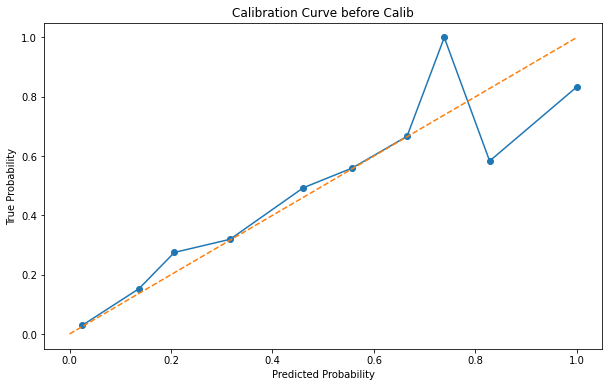

In [80]:
plt.figure(figsize=(10, 6))
plt.scatter(prob_pred, prob_true)
plt.plot(prob_pred, prob_true)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve before Calib')
plt.show()

### Conversion Rate

In [83]:
df_result = pd.DataFrame({'actual': y_test, 'predicted': y_pred_calibrated})
df_result.sort_values(by='predicted', ascending=False, inplace=True)

In [86]:
top_10 = df_result.head(int(df_result.shape[0] * 0.1))

In [87]:
top_10.actual.sum() / top_10.shape[0] * 100

37.022222222222226

### Explaination

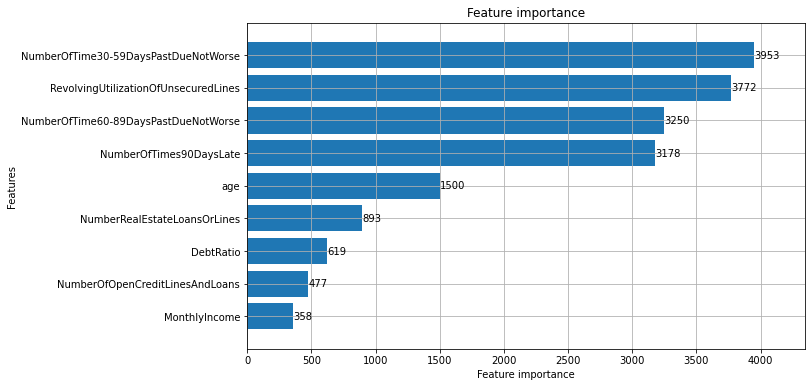

In [90]:
lgb.plot_importance(model, max_num_features=10, height=0.8, figsize=(10, 6));

In [95]:
y_exlain = y_test[y_test.index.isin([20909, 38562, 107330])]
X_explain = X_test[X_test.index.isin([20909, 38562, 107330])]

In [96]:
explainer = ClassifierExplainer(model, X_explain, y_exlain, X_background=X_train, n_jobs=8, target='Probability of Default', 
                                labels=['Not Default', 'Default'])

Generating self.shap_explainer = shap.TreeExplainer(model, X_background, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...


In [ ]:
ExplainerDashboard(explainer).run()

Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating pr auc curves...
Calculating prediction probabilities...
Calculating liftcurve_dfs...
Calculating classification_dfs...
Calculating confusion matrices...
Calculating pred_percentiles...
Calculating roc auc curves...
Calculating predictions...
Calculating metrics...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.jobl

 * Running on all addresses.
 * Running on http://192.168.1.8:8050/ (Press CTRL+C to quit)
192.168.1.8 - - [11/Jul/2021 16:21:21] "GET / HTTP/1.1" 200 -
192.168.1.8 - - [11/Jul/2021 16:21:21] "GET /_dash-component-suites/dash_renderer/prop-types@15.v1_9_1m1621491706.7.2.min.js HTTP/1.1" 200 -
192.168.1.8 - - [11/Jul/2021 16:21:21] "GET /_dash-component-suites/dash_renderer/polyfill@7.v1_9_1m1621491706.8.7.min.js HTTP/1.1" 200 -
192.168.1.8 - - [11/Jul/2021 16:21:21] "GET /_dash-component-suites/dash_renderer/react-dom@16.v1_9_1m1621491706.14.0.min.js HTTP/1.1" 200 -
192.168.1.8 - - [11/Jul/2021 16:21:21] "GET /assets/bootstrap.min.css?m=1621491710.294395 HTTP/1.1" 200 -
192.168.1.8 - - [11/Jul/2021 16:21:21] "GET /_dash-component-suites/dash_renderer/react@16.v1_9_1m1621491706.14.0.min.js HTTP/1.1" 200 -
192.168.1.8 - - [11/Jul/2021 16:21:21] "GET /_dash-component-suites/dash_bootstrap_components/_components/dash_bootstrap_components.v0_12_2m1621491710.min.js HTTP/1.1" 200 -
192.168.1.